Processing: 100%|███████████████████████████████████████████████████████████| 100000/100000 [10:36<00:00, 157.07item/s]


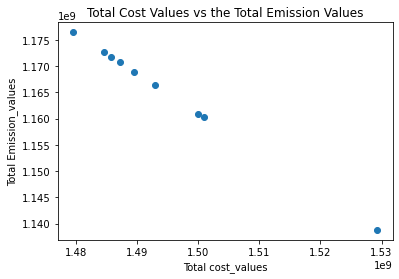

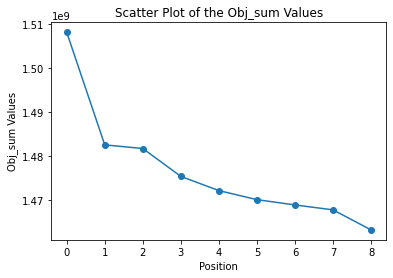

In [168]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import random

#Defining all parameters and variables

s = list(range(0,30))
p = list(range(0,6))
l = list(range(0,3))

Qspl = []  #Qspl[s][p][l]  #Quantity

#creating 30x6x3 list with 0 values
for i in range(len(s)):
    temp_p = []
    for j in range(len(p)):
        temp_l = [0]*len(l)
        temp_p.append(temp_l)
    Qspl.append(temp_p)
            
#creating 30x1
Ys = [0]*len(s)  #Supplier selection binary variable, 0 or 1

Zsl = []   #l selection by supplier binary variable, 0 or 1
for i in range(len(s)):
    temp_s = [0]*len(l)
    Zsl.append(temp_s)

FCs = []
CSl = np.array([8.46, 13.16, 7.14])
CNFl = np.array([7.67, 8.08, 8.6])
CPFl = np.array([5.22, 4.09, 4.11])
CKFl = np.array([5.04, 6.35, 5.16])
CHl = np.array([4.31, 5.72, 3.15])
CPl = np.array([0.19, 0.41, 0.19])
CMl = np.array([9.4, 6.14, 5.46])
CSPl = np.array([4.07, 3.21, 2.76])
COl = np.array([7.79, 6.23, 6.84])
CONSl = np.array([1.66, 2.59, 1.44]) 
CONNFl = np.array([10.2, 10.8, 11.6])
CONPFl = np.array([5.93, 4.55, 5.0])
CONKFl = np.array([7.69, 10.1, 8])
CONHl = np.array([0.02, 0.13, 0.06])
CONPl = np.array([0.001, 0.001, 0.001])
CONMl = np.array([1.17, 0.61, 1.01])
CONSPl = np.array([0.26, 0.19, 0.32])
CONOl = np.array([6.88, 4.39, 6.22])
CLAB = 12.85
CF = 4.18
AEF = 9.817
WT = 25

Dsp = []
for i in range(len(s)):
    Dsp.append([])
    
CEHl = np.array([184.8, 178, 189.8])
CEF = 0.048
CAPs = []
DEMp = np.array([660435, 660435, 1320870, 584231, 1524080, 1371672])

#Reading parameter values

#capacity
capacity = pd.read_excel('capacity.xlsx')
CAPs = list(capacity[" corn Production  ton"]) #capacities

#distance
distance = pd.read_excel('Distance.xlsx')
distance = distance.drop('Plant', axis=1)
for i in range(len(s)):
    for j in range(len(p)):
        Dsp[i].append(distance.iloc[i,j])
Dsp = np.array(Dsp)

#fixed cost
fixed_cost = pd.read_excel('Fixed cost.xlsx')
FCs = list(fixed_cost['Fixed cost'])
FCs = np.array(FCs)

#generating initial solution of the variables

CAPs_copy = CAPs.copy()
DEMp_copy = DEMp.copy()
for plant in range(len(p)):
    distance = distance.sort_values(distance.columns[plant]) #sort the plant column by minimum distance
    quant = 0
    index = 0
    remaining_demand = DEMp[plant]
    while quant < DEMp[plant]:
        supplier = distance.index[index]
        if CAPs[supplier] >= remaining_demand:  #if capacity is larger than demand
            quant = quant + remaining_demand
            
            #assign the decision variables Qspl, Zsl, Ys
            chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
            #Qspl[supplier][plant].append(remaining_demand)
            Qspl[supplier][plant][chosen_l] = remaining_demand
            if 1 not in Zsl[supplier]:    
                Zsl[supplier][chosen_l] = 1
            Ys[supplier] = 1
            
            CAPs[supplier] = CAPs[supplier] - remaining_demand
            remaining_demand = DEMp[plant] - quant
            
        else:
            quant = quant + CAPs[supplier]
            
            #Qspl[supplier][plant].append(CAPs[supplier])
            #assign the decision variables Qspl, Zsl, Ys
            chosen_l = random.choice([0, 1, 2])   #randomely choose one of the three harvesting style or l to be 1
            #Qspl[supplier][plant].append(remaining_demand)
            Qspl[supplier][plant][chosen_l] = CAPs[supplier]
            if 1 not in Zsl[supplier]:
                Zsl[supplier][chosen_l] = 1
            Ys[supplier] = 1
            
            remaining_demand = DEMp[plant] - quant
            index = index + 1
            CAPs[supplier] = 0

Qspl = np.array(Qspl)
Ys = np.array(Ys)
Zsl = np.array(Zsl)

"""
Function for getting the harvest cost with argument Qspl. All the other variables are global variables.

"""

def get_harvestCost(Qspl):
    #Getting the objective function value from generated variables and parameters

    ceHarvestingSum = 0   #Carbon emission harvesting, sum of CEHl * Qspl
    for supplier in Qspl:
        for plant in supplier:
            ceHarvestingSum = ceHarvestingSum + CEHl@plant

    transportSum = 0 #Carbon emission transportation, sum of DSp * Qspl
    for supplier in range(len(Qspl)):
        plant_ls = []
        for plant in Qspl[supplier]:
            sum_l = sum(plant)
            plant_ls.append(sum_l)
        plant_ls = np.array(plant_ls)
        transportSum = transportSum + Dsp[supplier]@plant_ls
    ceTransportSum = transportSum * CEF

    obj2=ceHarvestingSum+transportSum #objective Function 2

    FC=Ys@FCs #Fixed cost 

    cons1 = CSl * CONSl #cost for seedbeds
    csSum = 0
    for supplier in Qspl:
        for plant in supplier:
            csSum = csSum + cons1@plant


    cons2 = CNFl * CONNFl #cost for N fertilizer
    cnfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cnfSum = cnfSum + cons2@plant


    cons3 = CPFl * CONPFl #cost for P fertilizer
    cpfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cpfSum = cpfSum + cons3@plant


    cons4 = CKFl * CONKFl #cost for K fertilizer
    ckfSum = 0
    for supplier in Qspl:
        for plant in supplier:
            ckfSum = ckfSum + cons4@plant


    cons5 = CHl * CONHl # cost for herbicides
    chSum = 0
    for supplier in Qspl:
        for plant in supplier:
            chSum = chSum + cons5@plant


    cons6 = CPl * CONPl #cost for pesticides
    cpSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cpSum = cpSum + cons6@plant


    cons7 = CMl * CONMl #cost for machinaries
    cmSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cmSum = cmSum + cons7@plant


    cons8 = CSPl * CONSPl #cost for spare parts
    cspSum = 0
    for supplier in Qspl:
        for plant in supplier:
            cspSum = cspSum + cons8@plant


    cons9 = COl * CONOl #cost for oil
    coSum = 0
    for supplier in Qspl:
        for plant in supplier:
            coSum = coSum + cons9@plant


            qsplSum = 0 #labour cost
    for supplier in Qspl:
        for plant in supplier:
            qsplSum = qsplSum + sum(plant)
    clabSum = CLAB * qsplSum


    harvestCost=csSum+cnfSum+cpfSum+ckfSum+chSum+cpSum+cmSum+cspSum+coSum+clabSum #Harvesting cost
    
    return harvestCost

"""
Function for getting the TransportCost with argument Qspl. All the other variables are global variables.

"""

def get_TransportCost(Qspl):
    
    transportSum = 0 #Carbon emission transportation, sum of DSp * Qspl
    for supplier in range(len(Qspl)):
        plant_ls = []
        for plant in Qspl[supplier]:
            sum_l = sum(plant)
            plant_ls.append(sum_l)
        plant_ls = np.array(plant_ls)
        transportSum = transportSum + Dsp[supplier]@plant_ls
    
    transportCost = (transportSum*CF)/(AEF*WT) #transportation cost
    
    return transportCost

"""
Function for getting the obj2 with argument Qspl. All the other variables are global variables.

"""

def get_obj2(Qspl):
    ceHarvestingSum = 0   #Carbon emission harvesting, sum of CEHl * Qspl
    for supplier in Qspl:
        for plant in supplier:
            ceHarvestingSum = ceHarvestingSum + CEHl@plant

    transportSum = 0 #Carbon emission transportation, sum of DSp * Qspl
    for supplier in range(len(Qspl)):
        plant_ls = []
        for plant in Qspl[supplier]:
            sum_l = sum(plant)
            plant_ls.append(sum_l)
        plant_ls = np.array(plant_ls)
        transportSum = transportSum + Dsp[supplier]@plant_ls
    ceTransportSum = transportSum * CEF

    obj2=ceHarvestingSum+ceTransportSum #objective Function 2
    
    return obj2

#Initial objective function calculation

w1 = .94582704672

#random.uniform(0, 1) #randomly generated weights
w2 = 1 - w1
FC=Ys@FCs
harvestCost = get_harvestCost(Qspl)
TransportCost = get_TransportCost(Qspl)

obj1 = FC+harvestCost+TransportCost  #Objective Function 1
obj2 = get_obj2(Qspl)

obj_sum=w1*obj1+w2*obj2

"""
Iteration for random selection of harvesting style (l)

"""

from tqdm import tqdm
import time

obj1_list = []
obj2_list = []
obj_sum_list = []

# Make a copy of the original array
Qspl_copy = np.copy(Qspl)

Zsl_copy = np.zeros_like(Zsl)  # Assuming Zsl has shape (30, 3)

harvestCost = get_harvestCost(Qspl)


for itr in tqdm(range(100000), desc="Processing", unit="item"):
    
    # Randomly shuffle the selection of harvesting styles and create new Qspl_copy and Zsl_copy everytime
    for i in range(Qspl_copy.shape[0]):
        for j in range(Qspl_copy.shape[1]):
            np.random.shuffle(Qspl_copy[i, j])
    
    for i in range(Qspl_copy.shape[0]):
        for j in range(Qspl_copy.shape[1]):
            non_zero_position = np.where(Qspl_copy[i, j] != 0)[0]  # Get the position of non-zero element
            if non_zero_position.size > 0:  # If a non-zero element exists
                Zsl_copy[i, non_zero_position[0]] = 1
                
    new_harvestCost = get_harvestCost(Qspl_copy)
#     print("harvest cost for iteration - ", itr+1, new_harvestCost)
    
    #1st Accepting criteria of the random selection, new harvestCost has be between 80% and 120% of the old harvestCost
    if new_harvestCost> 0.9*harvestCost and new_harvestCost< 1.1*harvestCost:
        harvestCost = new_harvestCost
#         print("harvest cost changed for iteration - ", itr+1, harvestCost)
        TransportCost = get_TransportCost(Qspl_copy)
        
        obj2 = get_obj2(Qspl_copy)
        obj1 = FC+harvestCost+TransportCost
        new_obj_sum=w1*obj1+w2*obj2
#         print("obj_sum for iteration - ", itr+1, new_obj_sum)
        
    
        #2nd Accepting criteria of the random selection, new objective function has to be better than the previous one
        if new_obj_sum < obj_sum:
            obj_sum = new_obj_sum
#             print("obj_sum changed for iteration - ", itr+1, obj_sum)
            
            #Store the obj1 and obj2
            obj1_list.append(obj1)
            obj2_list.append(obj2)
            obj_sum_list.append(obj_sum)
        else:
            continue
        
    else:
        continue

import matplotlib.pyplot as plt


# Create scatter plot
plt.scatter(obj1_list, obj2_list)

# Set labels and title
plt.xlabel('Total cost_values')
plt.ylabel('Total Emission_values')
plt.title('Total Cost Values vs the Total Emission Values')

# Display the plot
plt.show()


import matplotlib.pyplot as plt

# Create scatter plot
plt.plot(range(len(obj_sum_list)), obj_sum_list,marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Obj_sum Values')
plt.title('Scatter Plot of the Obj_sum Values')

# Display the plot

plt.show()



In [169]:
obj1_list

[1529326744.0379186,
 1500968230.4514384,
 1500065404.9390385,
 1493037992.8551586,
 1489469912.5241985,
 1487190675.4073985,
 1485854809.4525986,
 1484618312.5907986,
 1479573723.0681987]

In [170]:
min (obj1_list)

1479573723.0681987

In [171]:
min (obj2_list)

1138764491.424475

In [172]:
obj2_list

[1138764491.424475,
 1160323584.624475,
 1160886390.624475,
 1166312154.824475,
 1168917671.2244751,
 1170674007.2244751,
 1171698481.2244751,
 1172628402.2244751,
 1176413391.2244751]

In [173]:
w1

0.94582704672

In [174]:
obj_sum_list

[1508168833.3741589,
 1482514503.967972,
 1481691076.043019,
 1475338289.2961535,
 1472104650.9324691,
 1470044032.7295835,
 1468836033.3608801,
 1467716897.7526925,
 1463150632.5748794]

In [175]:
min(obj_sum_list)

1463150632.5748794

In [176]:
Qspl

array([[[      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0, 1231000,       0],
        [      0,       0,       0]],

       [[      0,       0,       0],
        [      0,       0,       0],
        [      0, 1138475,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0]],

       [[      0,       0,       0],
        [      0,  587825,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0]],

       [[      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0],
        [      0,       0,       0]],

       [[      0,       0,       0],
        [      0,   72610,       0],
        [      0,       0,    

In [177]:
Ys

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1])

In [178]:
Zsl

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [1, 0, 0]])